# INF8111 - Fouille de données


## TP1 Automne 2019 - Preprocessing de tweets pour de l'analyse de sentiments

##### Membres de l'équipe:

    - Rodolphe Picot (1993713)
    - Amine Badaoui (1980268)
    - Omar Talbi   (1912353)
    
références:
- www.ntlk.org
- https://scikit-learn.org/
- http://zetcode.com/python/prettytable/
- https://matplotlib.org/
- https://spacy.io/

## Présentation

Twitter est un réseau social permettant aux utilisateurs de publier des informations et communiquer entre eux par le biais de messages, appelés tweets, pouvant contenir jusqu'à 280 caractères. Largement utilisé aujourd'hui, ce réseau peut être un outil pour des entreprises qui souhaitent évaluer l'avis de leurs clients.

Dans ce TP, on se met à la place d'une compagnie aérienne, qui souhaiterait détecter les tweets qui la mentionnent et analyser si ce sont des mentions positives ou négatives, en comparant leur résultat avec les autres compagnies.

Le *preprocessing* est une tâche cruciale en fouille de données. Elle permet de transformer les données brutes en un format adapté à l'application de méthodes de machine learning.

# I/ Analyse de sentiments (13 Pts)

Usuellement dans la littérature, la tâche d'extraire le sentiment d'un texte est appelé *sentiment analysis*.
Ici pour se faire, nous allons utiliser un modèle *bag-of-words* (BoW).

## 1. Installation

Pour ce TP, vous aurez besoin des librairies `numpy`, `sklearn` et `scipy` (que vous avez sans doute déjà), ainsi que la librairie `nltk`, qui est une libraire utilisée pour faire du traitement du language (Natural Language Processing, NLP)

Installez les libraires en question et exécutez le code ci-dessous :

In [1]:
# If you want, you can use anaconda and install after nltk library
#!pip install --user numpy
#!pip install --user sklearn
#!pip install --user scipy
#!pip install --user nltk

import sys
import nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("universal_tagset")


[nltk_data] Downloading package punkt to /home/gx1s/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/gx1s/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/gx1s/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/gx1s/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

## 2. Jeu de données

On utilise un jeu de donnée provenant de *Crowdflower's Data for Everyone library*: https://www.figure-eight.com/data-for-everyone/

Pour citer la source originale de la base :

    A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

Les compagnies incluses dans cette base de données sont Virgin America, United Airline, Southwest Airlines, jetBlue, USAirways, et American Airlines.

Dans le fichier zip du TP, vous trouverez le fichier *airline_tweets_database.csv*, qui est la base de données de tweets que nous allons manipuler.

Chaque ligne de ce fichier contient un tweet, avec plusieurs informations : l'identifiant du tweet, l'utilisateur, le contenu, le nombre de retweet... Ainsi que le label.

3 labels différents sont possibles dans ce dataset : *négatif*, *neutre* et *positif*, que l'on va représenter respectivement par 0, 1 et 2.

Pour ce TP, on ne va conserver ici que le texte et le label. On divise ensuite la base de données en 3 ensembles (entrainement/validation/test). Vous utiliserez l'ensemble d'entraînement et de validation pour cette partie, et l'ensemble de test à la partie suivante.

Le code ci-dessous permet de charger ces ensembles:

In [2]:
import csv

from sklearn.model_selection import train_test_split

def load_dataset(path):
    
    texts = []
    scores = []

    with open(path, 'r', newline='', encoding="latin-1") as csvfile:
        
        reader = csv.reader(csvfile, delimiter=',')
        
        # Taking the header of the file + the index of useful columns:
        header = next(reader)
        ind_label = header.index('airline_sentiment')
        ind_text = header.index('text')
        
        for row in reader:
            texts.append(row[ind_text])
            
            label = row[ind_label]
            
            if label == "negative":
                scores.append(0)
            elif label == "neutral":
                scores.append(1)
            elif label == "positive":
                scores.append(2)

        assert len(texts) == len(scores)

        return texts, scores


# Path of the dataset
path = "data/airline_tweets_database.csv"

texts_data, scores_data = load_dataset(path)

train_valid_X, test_X, train_valid_Y, test_Y = train_test_split(texts_data, scores_data, test_size=0.15, random_state=12)

train_X, valid_X, train_Y, valid_Y = train_test_split(train_valid_X, train_valid_Y, test_size=0.18, random_state=12)
print("Length of training set : ", len(train_X))
print("Length of validation set : ", len(valid_X))
print("Length of test set : ", len(test_X))


Length of training set :  10204
Length of validation set :  2240
Length of test set :  2196


## 3. Preprocessing

Nous allons ici implémenter la *tokenization* et le *stemming*, qui sont 2 étapes courantes de preprocessing en NLP. Ensuite, afin d'avoir un modèle qui s'adapte mieux au format de Twitter, nous ajouterons une étape spécifique supplémentaire.

### 3.1. Tokenization

Cette étape permet de séparer un texte en séquence de *tokens* (= jetons, ici des mots, symboles ou ponctuation).

Par exemple la phrase *"It's the student's notebook."* peut être séparé en liste de tokens de cette manière: ["it", " 's", "the", "student", " 's", "notebook", "."].

**De plus, tous les tokenizers ont également le rôle de mettre le texte en minuscule.**


##### Question 1. Implémentez les 2 tokenizers différents suivants: (0.5 Pts)

- Le **SpaceTokenizer**, qui est un tokenizer naïf qui sépare simplement en fonction des espaces.
- Le **NLTKTokenizer**, qui utilise la méthode du package *nltk* (https://www.nltk.org/api/nltk.html).


In [3]:
from nltk.tokenize import TweetTokenizer

class SpaceTokenizer(object):
    """
    It tokenizes the tokens that are separated by whitespace (space, tab, newline). 
    We consider that any tokenization was applied in the text when we use this tokenizer.

    For example: "hello\tworld of\nNLP" is split in ['hello', 'world', 'of', 'NLP']
    """

    def tokenize(self, text):
        import re
        # on fait attention à ne pas de token vide
        return list(filter(lambda token: token != "", re.split(' |\n|\t', text)))


class NLTKTokenizer(object):
    """
    This tokenizer uses the default function of nltk package (https://www.nltk.org/api/nltk.html) to tokenize the text.
    """

    def tokenize(self, text):
        from nltk.tokenize import word_tokenize        
        return word_tokenize(text)
    
text = "it's ok \n no ?"

print("Text: " + text)
print("Space token: " + str(SpaceTokenizer().tokenize(text)))

nltk_tokeniser = NLTKTokenizer()
nltk_tokens = nltk_tokeniser.tokenize(text)
print("NLTK token: " + str(nltk_tokens))



Text: it's ok 
 no ?
Space token: ["it's", 'ok', 'no', '?']
NLTK token: ['it', "'s", 'ok', 'no', '?']


#### Testez les deux tokenizers. Quelles différences pouvez-vous constater?

Les mots ayant comme séparation un autre caractère que espace forment
un seul mot avec le mot les précédant pour le tokenizer naïf.

Alors qu'avec le NLTK tokenizer, il a une analyse plus fine des séparations entre les mots dans le langage naturel, si on prend l'exemple suivant
Hi Mr. Smith today.
["Mr."] sera consédiré comme un token alors today. sera considéré comme ["today","."]


### 3.2. Troncature (ou Stemming)

Dans les phrases "I should have bought a new shoes today" et "I spent too much money buying games", les mots "buying" et "bought" représentent la même idée. Considérer ces deux mots comme différents ne ferait qu'augmenter pour rien la complexité et la dimension du problème, ce qui peut avoir un impact négatif sur la performance globale. Ainsi, on peut donc plutôt une forme unique (comme la racine du mot) pour représenter ces deux mots de la même manière. Ce procédé de conversion de mots en racines permettant de réduire la dimension est appelé usuellement *stemming*, que l'on peut traduire par troncature.


#### Question 2. Récupérez les troncatures des tokens en utilisant l'attribut *stemmer* de la classe *Stemmer* (0.5 Pts) 

In [4]:
from nltk.stem.snowball import SnowballStemmer


class Stemmer(object):

    def __init__(self):
        self.stemmer = SnowballStemmer("english", ignore_stopwords=True)

    def stem(self, tokens):
        """
        tokens: a list of strings
        """
        return [self.stemmer.stem(token) for token in tokens]
    
text_stem = "I should have bought a new shoes today I spent too much money buying games"

tokens = nltk_tokeniser.tokenize(text_stem)

print(Stemmer().stem(tokens))


['i', 'should', 'have', 'bought', 'a', 'new', 'shoe', 'today', 'i', 'spent', 'too', 'much', 'money', 'buy', 'game']


### 3.3. Twitter preprocessing

Parfois, appliquer uniquement ces deux étapes ne suffit pas, due aux particularités des données que nous manipulons, qui peuvent demander des étapes de preprocessing spécifiques afin d'obtenir un modèle plus adapté.

Couramment en NLP, un dictionnaire est utilisé pour stocker un ensemble de mots, et tous les mots n'appartenant pas au dictionnaire sont considérés comme inconnus. Ainsi, avec ce choix d'implémentation, la dimension de l'espace caractéristique du modèle est directement liée au nombre de mots du dictionnaire. Ainsi, pour des raisons de complexité mais aussi car les modèles à trop grande dimension peuvent souffrir du fléau de la dimensionnalité, il est préférable de réduire la taille de notre vocabulaire.

#### Question 3. Donnez, en expliquant brièvement, au moins deux exemples d'étapes de préprocessing qui permettent de réduire la taille du dictionnaire ici, puis implémentez-les.  (2.0 points)

Ces étapes de préprocessing doivent être en rapport aux charactéristiques spécifiques des données de Twitter. La suppression des mots vides ne compte pas comme une des deux étapes.



Réponse: Twitter permet de taguer des personnes ou mettre des hashtags, nous pouvons déjà enlever ou labelliser de manière spécifique des mots commençant par '@' ou '#'. Donc avec la phrase "@toto tu vas bien ? #FeteDeLHuma" ressortir "tu vas bien" ou "TwitterAccount tu vas bien ? Festival"

Comme de nombreux réseaux sociaux, on peut ajouter des smileys dans les tweets. On pourrait donc les énumérer et les remplacer par un mot caractérisant l'émotion du smiley. Dans la même idée, on peut ajouter les abréviations, par exemple "WTF" marquerait la surprise.

On peut aussi remplacer les liens par le mot "URL"

In [5]:
import string


class TwitterPreprocessing(object):

    def preprocess(self, tweet):
        """
        tweet: original tweet
        """
        import re
        # on considère que les pseudos twitter n'ont pas de caractères spéciaux
        tweet_preproc = re.sub("@[a-zA-Z0-9]*", "TWITTERACCOUNT", tweet)
        tweet_preproc = re.sub("[,.:;!?]", "", tweet_preproc)
        
        #Pour le moment nous allons juste enlever les hashtags sans les traiter 
        tweet_preproc = re.sub("#[a-zA-Z0-9]*", "HASHTAG", tweet_preproc)
                
        #Regex naïve pour trouver les URLs, son but est seulement de montrer un exemple
        regexURL = "www.[a-zA-Z0-9]*.[a-zA-Z]*"
        tweet_preproc = re.sub(regexURL, "URL", tweet_preproc)
              
        #De même en ce qui concerne les smileys
        smileys = {":\)" : "HAPPY",
                   ":-\)": "HAPPY"
                  }
        
        for smiley in smileys:
            tweet_preproc = re.sub(smiley, smileys[smiley], tweet_preproc)
        
        
        return tweet_preproc

    
tweet_test = "coucou @Toto, tu vas bien ? :) viens à la #FeteDeLHuma, voici le lien pour le ticket www.ticketfetedelhumafake.fr"
twitter_preproc = TwitterPreprocessing()

print(twitter_preproc.preprocess(tweet_test))



coucou TWITTERACCOUNT tu vas bien  ) viens à la HASHTAG voici le lien pour le ticket URL


### 3.4.  Pipeline

Une pipeline permet d'exécuter séquentiellement toutes les étapes de preprocessing, pour transformer les données brutes en une version utilisable pour notre modèle. La *PreprocessingPipeline* a été implémenter pour appliquer à la suite le tokenizer, les troncatures et le preprocessing spécifique à Twitter. 

**N'hésitez pas à changer l'ordre des étapes de preprocessing si vous le souhaitez.**

In [6]:
class PreprocessingPipeline:

    def __init__(self, tokenization, twitterPreprocessing, stemming):
        """
        tokenization: enable or disable tokenization.
        twitterPreprocessing: enable or disable twitter preprocessing.
        stemming: enable or disable stemming.
        """

        self.tokenizer = NLTKTokenizer() if tokenization else SpaceTokenizer()
        self.twitterPreprocesser = TwitterPreprocessing(
        ) if twitterPreprocessing else None
        self.stemmer = Stemmer() if stemming else None

    def preprocess(self, tweet):
        """
        Transform the raw data

        tokenization: boolean value.
        twitterPreprocessing: boolean value. Apply the
        stemming: boolean value.
        """
        
        if self.twitterPreprocesser:
            tweet = self.twitterPreprocesser.preprocess(tweet)

        tokens = self.tokenizer.tokenize(tweet)
                
        if self.stemmer:
            tokens = self.stemmer.stem(tokens)
            
        return tokens


Test de la pipeline :

In [7]:
pipeline = PreprocessingPipeline(tokenization=True, twitterPreprocessing=True, stemming=True)
print(list(map(pipeline.preprocess, train_X[:1])))

[['twitteraccount', 'tell', 'me', 'to', 'talk', 'to', 'twitteraccount', 'about', 'my', 'delay', 'flight', 'aa', 'tell', 'me', 'to', 'talk', 'to', 'us', 'hashtag']]


## 4. N-grams

Un n-gram est une séquence continue de *n* tokens dans un texte. Par exemple, les séquences *"nous a"* et *"la porte"* sont deux exemples de 2-grams de la phrase *"Il nous a dit au revoir en franchissant la porte."*. 1-gram, 2-gram et 3-gram sont respectivement appelés unigram, bigram et trigram. 

Voici la liste de tous les unigrams, bigrams et trigrams possible pour la phrase *"Il nous a dit au revoir en franchissant la porte."* :
- Unigram: ['Il', 'nous', 'a', 'dit', 'au', 'revoir', 'en', 'franchissant', 'la', 'porte']
- Bigram: ['Il nous', 'nous a', 'a dit', 'dit au', 'au revoir', 'revoir en', 'en franchissant', 'franchissant la', 'la porte']
- Trigram: ['Il nous a', 'nous a dit', 'a dit au', 'dit au revoir', 'au revoir en', 'revoir en franchissant', 'en franchissant la', 'franchissant la porte']


##### Question 4. Implementez les fonctions `bigram` et `trigram`. (1 Pt)

Vous devez résoudre cette question sans utiliser de libraire exterieur comme scikit-learn par exemple.

In [8]:
def n_grams(tokens, n):
    """
    tokens: a list of strings
    n an integer
    """
    grams = []
    for i in range(len(tokens) - n + 1):
        grams.append(" ".join(tokens[i:i + n]))
    return grams


def bigram(tokens):
    """
    tokens: a list of strings
    """
    return n_grams(tokens, 2)


def trigram(tokens):
    """
    tokens: a list of strings
    """
    return n_grams(tokens, 3)

tokens = ['Il', 'nous', 'a', 'dit', 'au', 'revoir', 'en', 'franchissant', 'la', 'porte']
res_big = ['Il nous', 'nous a', 'a dit', 'dit au', 'au revoir', 'revoir en', 'en franchissant', 'franchissant la', 
           'la porte']

res_tri =  ['Il nous a', 'nous a dit', 'a dit au', 'dit au revoir', 'au revoir en', 'revoir en franchissant',
            'en franchissant la', 'franchissant la porte']

assert bigram(tokens) == res_big
assert trigram(tokens) == res_tri

## 5. Bag-of-words

Régressions logistiques, SVM et d'autres modèles très courants demande des entrées qui soient toutes de la même taille, ce qui n'est forcément le cas pour des types de données comme les textes, qui peuvent avoir un nombre variable de mots.  

Par exemple, considérons la phrase 1, ”Board games are much better than video games” et la phrase 2, ”Pandemic is an awesome game!”. La table ci-dessous montre un exemple d'un moyen de représentation de ces deux phrases en utilisant une représentation fixe : 

|<i></i>     | an | are | ! | pandemic | awesome | better | games | than | video | much | board | is | game |
|------------|----|-----|---|----------|---------|--------|-------|------|-------|------|-------|----|------|
| Sentence 1 | 0  | 1   | 0 | 0        | 0       | 1      | 2     | 1    | 1     | 1    | 1     | 0  | 0    |
| Sentence 2 | 1  | 0   | 0 | 1        | 1       | 0      | 0     | 0    | 0     | 0    | 0     | 1  | 1    |


Chaque colonne représente un mot du vocabulaire (de longueur 13), tandis que chaque ligne contient l'occurence des mots dans une phrase. Ainsi, la valeur 2 à la position (1,7) est due au fait que le mot *"games"* apparait deux fois dans la phrase 1. 

Ainsi, chaque ligne étant de longueur 13, on peut les utiliser comme vecteur pour représenter les phrases 1 et 2. Ainsi, c'est cette méthode que l'on appelle *Bag-of-Words* : c'est une représentation de documents par des vecteurs dont la dimension est égale à la taille du vocabulaire, et qui est construit en comptant le nombre d'occurence de chaque mot. Ainsi, chaque token est ici associé à une dimension.


##### Question 5. Implémentez le Bag-of-Words  (2 Pts)

Pour cette question, vous ne pouvez pas utiliser de librairie Python externe comme scikit-learn, hormis si vous avez des problèmes de mémoire, vous pouvez utiliser la classe sparse.csr_matrix de scipy (https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html).

In [9]:
from scipy.sparse import csr_matrix, csc_matrix
import numpy as np

class CountBoW(object):

    def __init__(self, pipeline, bigram=False, trigram=False):
        """
        pipelineObj: instance of PreprocesingPipeline
        bigram: enable or disable bigram
        trigram: enable or disable trigram
        words: list of words in the vocabulary
        """
        self.pipeline = pipeline
        self.bigram = bigram
        self.trigram = trigram
        self.words = None

    def add_local_dict(self, tokens, local_dict, len_gramms, index):
        
        gram = " ".join(tokens[index:index + len_gramms])
        if gram in local_dict:
            local_dict[gram] = local_dict[gram] + 1
        else:
            local_dict[gram] = 1
        
    def computeBoW(self, tokens_X):
        """
        Calcule du BoW, à partir d'un dictionnaire de mots et d'une liste de tweets.
        On suppose que l'on a déjà collecté le dictionnaire sur l'ensemble d'entraînement.

        Entrée: tokens, une liste de vecteurs contenant les tweets

        Return: une csr_matrix
        """

        if self.words is None:
            raise Exception(
                "fit_transform() should be called first (no dictionnary available)"
            )

        row = []
        col = []
        data = []

        for index_row, tokens in enumerate(tokens_X, start=0):
            dict_count_world_tokens = {}
            
            length_tokens = len(tokens)
            for i in range(length_tokens):
                
                self.add_local_dict(tokens, dict_count_world_tokens, 1, i)        
                    
                if self.bigram and i < length_tokens - 1: 
                    self.add_local_dict(tokens, dict_count_world_tokens, 2, i)
                        
                if self.trigram and i < length_tokens - 2:
                    self.add_local_dict(tokens, dict_count_world_tokens, 3, i)
            
            try:
                for gram, count in dict_count_world_tokens.items():
                    col.append(self.words[gram])
                    row.append(index_row)
                    data.append(dict_count_world_tokens[gram])
            except KeyError:
                continue

        return csr_matrix((data, (row, col)), shape=(len(tokens_X), len(self.words)))

    def generate_dict(self, tokens_x, len_grams):
        
        if self.words is None:
            self.words = {}
        
        index = len(self.words)
        
        for tokens in tokens_x:
            grams = n_grams(tokens, len_grams)
            for gram in grams:
                if gram not in self.words:
                    self.words[gram] = index
                    index = index + 1
    
    
    def fit_transform(self, X):
        """
        Cette méthode preprocess les données en utilisant la pipeline, ajoute les bigram et trigram
        si besoin, et transforme les textes en vecteurs d'entiers.

        Entrée: X, une liste de vecteurs contenant les tweets

        Return: une csr_matrix
        """

        tokens_x = list(map(self.pipeline.preprocess, X))
        
        self.generate_dict(tokens_x, 1)
                            
        if self.bigram:
            self.generate_dict(tokens_x, 2)
            
        if self.trigram:
            self.generate_dict(tokens_x, 3)
        
        return self.computeBoW(tokens_x)

    def transform(self, X):
        """
        Cette méthode preprocess les données en utilisant la pipeline, ajoute les bigram et trigram
        si besoin, et transforme les textes en vecteurs d'entiers.
        Différence avec fit_transform : on suppose qu'on dispose déjà du dictionnaire ici

        Entrée: X, une liste de vecteurs contenant les tweets

        Return: une csr_matrix
        """

        if self.words is None:
            raise Exception(
                "fit_transform() should be called first (no dictionnary available)"
            )

        tokens_x = list(map(self.pipeline.preprocess, X))
        
        return self.computeBoW(tokens_x)
    
    def clear(self):
        self.words = None


c = CountBoW(PreprocessingPipeline(True,True,True), True, True)

tweets = ["I love pizza ", 
          "Where is Bryan ?", 
          "Bryan is in the kitchen, if he's not in kitchen, he's in bathroom"]

compute = c.fit_transform(tweets)

print(c.words)

#print("coucou" + str(compute[0][0]))


#print("\n\n\n\n")

#test_bow = CountBoW(PreprocessingPipeline(True,True,True), True, True)

#compute2 = test_bow.fit_transform(train_X)
#print(len(test_bow.words))

#print(compute2)







{'i': 0, 'love': 1, 'pizza': 2, 'where': 3, 'is': 4, 'bryan': 5, 'in': 6, 'the': 7, 'kitchen': 8, 'if': 9, 'he': 10, "'s": 11, 'not': 12, 'bathroom': 13, 'i love': 14, 'love pizza': 15, 'where is': 16, 'is bryan': 17, 'bryan is': 18, 'is in': 19, 'in the': 20, 'the kitchen': 21, 'kitchen if': 22, 'if he': 23, "he 's": 24, "'s not": 25, 'not in': 26, 'in kitchen': 27, 'kitchen he': 28, "'s in": 29, 'in bathroom': 30, 'i love pizza': 31, 'where is bryan': 32, 'bryan is in': 33, 'is in the': 34, 'in the kitchen': 35, 'the kitchen if': 36, 'kitchen if he': 37, "if he 's": 38, "he 's not": 39, "'s not in": 40, 'not in kitchen': 41, 'in kitchen he': 42, "kitchen he 's": 43, "he 's in": 44, "'s in bathroom": 45}


## 6. TF-IDF

L'utilisation de la fréquence d'apparition brute des mots, comme c'est le cas avec le bag-of-words, peut être problématique. En effet, peu de tokens auront une fréquence très élevée dans un document, et de ce fait, le poids de ces mots sera beaucoup plus grand que les autres, ce qui aura tendance à biaiser l'ensemble des poids. De plus, les mots qui apparaissent dans la plupart des documents n'aident pas à les discriminer. Par exemple, le mot "*de*" apparaît dans beaucoup de tweets de la base de données, et pour autant, avoir ce mot en commun ne permet pas de conclure que des tweets sont similaires. Au contraire, le mot "*génial*" est plus rare, mais les documents qui contiennent ce mot sont plus susceptibles d'être positif. TF-IDF est donc une méthode qui permet de pallier à ce problème.

TF-IDF pondère le vecteur en utilisant une fréquence de document inverse (IDF) et une fréquence de termes (TF).

TF est l'information locale sur l'importance qu'a un mot dans un document donné, tandis que IDF mesure la capacité de discrimination des mots dans un jeu de données. 

L'IDF d'un mot se calcule de la façon suivante:

\begin{equation}
	\text{idf}_i = \log\left( \frac{N}{\text{df}_i} \right),
\end{equation}

avec $N$ le nombre de documents dans la base de donnée, et $\text{df}_i$ le nombre de documents qui contiennent le mot $i$.

Le nouveau poids $w_{ij}$ d'un mot $i$ dans un document $j$ peut ensuite être calculé de la façon suivante:

\begin{equation}
	w_{ij} = \text{tf}_{ij} \times \text{idf}_i,
\end{equation}

avec $\text{tf}_{ij}$ la fréquence du mot $i$ dans le document $j$.




##### Question 6. Implémentez le bag-of-words avec la pondération de TF-IDF (3 Pts)

Pour cette question, vous ne pouvez pas utiliser de librairie Python externe comme scikit-learn, hormis si vous avez des problèmes de mémoire, vous pouvez utiliser la classe sparse.csr_matrix de scipy (https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html).

In [10]:
from scipy.sparse import csr_matrix
import math


class TFIDFBoW(object):

    def __init__(self, pipeline, bigram=False, trigram=False):
        """
        pipelineObj: instance of PreprocesingPipeline
        bigram: enable or disable bigram
        trigram: enable or disable trigram
        words: list of words in the vocabulary
        idf: list of idfs for each document
        """
        self.pipeline = pipeline
        self.bigram = bigram
        self.trigram = trigram
        self.words = None
        self.idf = None
        
    def add_local_dict_TFIDF(self, tokens, local_dict, len_gramms, index, local_TFIDF):
        
        gram = " ".join(tokens[index:index + len_gramms])
        
        if gram not in local_TFIDF:
            local_TFIDF.append(gram)
        if gram in local_dict:
            local_dict[gram] = local_dict[gram] + 1
        else:
            local_dict[gram] = 1
        
    def computeTFIDF(self, X):
        """
        Calcule du TF-IDF, à partir d'un dictionnaire de mots et d'une 
        liste de tweets.
        On suppose que l'on a déjà collecté le dictionnaire ainsi que 
        calculé le vecteur contenant l'idf pour chaque document.
        
        Entrée : X, une liste de vecteurs contenant les tweets
        
        Return: une csr_matrix
        """
       
        row = []
        col = []
        data = []

        self.idf = {}
        for index_row, tokens in enumerate(X, start=0):
            dict_count_world_tokens = {}
            TFIDF_local = []
            length_tokens = len(tokens)
            for i in range(length_tokens):
                
                self.add_local_dict_TFIDF(tokens, dict_count_world_tokens, 1, i, TFIDF_local)        
                 
                if self.bigram and i < length_tokens - 1:  
                    self.add_local_dict_TFIDF(tokens, dict_count_world_tokens, 2, i, TFIDF_local)
                        
                if self.trigram and i < length_tokens - 2:
                    self.add_local_dict_TFIDF(tokens, dict_count_world_tokens, 3, i, TFIDF_local)
                
            try:
                for gram, count in dict_count_world_tokens.items():
                    
                    col.append(self.words[gram])
                    row.append(index_row)
                    data.append(float(dict_count_world_tokens[gram]))
            except KeyError:
                continue
                
            for gram in TFIDF_local:
                if gram in self.idf:
                    self.idf[gram].append(index_row)
                else:
                    self.idf[gram] = [index_row]
                
        matrice = csr_matrix((data, (row, col)), shape=(len(X), len(self.words)))
        try:
            for gram, col_index in self.words.items():
                list_tweet_row = self.idf[gram]
                for tweet_row in list_tweet_row:
                    matrice[tweet_row, col_index] *= math.log(len(X)/len(list_tweet_row))
        except KeyError:
            pass
        return matrice
    
    def generate_dict(self, tokens_x, len_grams):
        
        if self.words is None:
            self.words = {}
        
        index = len(self.words)
        
        for tokens in tokens_x:
            grams = n_grams(tokens, len_grams)
            for gram in grams:
                if gram not in self.words:
                    self.words[gram] = index
                    index = index + 1
        

    def fit_transform(self, X):
        """
        Cette méthode preprocess les données en utilisant la pipeline, ajoute les bigram et trigram 
        si besoin, et transforme les textes en vecteurs de flottants avec la pondération TF-IDF.
        
        Entrée : X, une liste de vecteurs contenant les tweets
        
        Return: une csr_matrix
        """
        tokens_x = list(map(self.pipeline.preprocess, X))
        
        self.generate_dict(tokens_x, 1)
                            
        if self.bigram:
            self.generate_dict(tokens_x, 2)
            
        if self.trigram:
            self.generate_dict(tokens_x, 3)
        
        return self.computeTFIDF(tokens_x)

    def transform(self, X):
        """
        Cette méthode preprocess les données en utilisant la pipeline, ajoute les bigram et trigram 
        si besoin, et transforme les textes en vecteurs de flottants avec la pondération TF-IDF.
        Différence avec fit_transform : on suppose qu'on dispose déjà du dictionnaire et du calcul des idf ici.
            
        Entrée : X, une liste de vecteurs contenant les tweets
        
        Return: une csr_matrix
        """

        if self.words is None:
            raise Exception(
                "fit_transform() should be called first (no dictionnary available)"
            )

        tokens_x = list(map(self.pipeline.preprocess, X))
        
        return self.computeTFIDF(tokens_x)
    
    
c2 = TFIDFBoW(PreprocessingPipeline(True,True,True), True, True)

tweets = ["I love pizza "]

compute = c2.fit_transform(tweets)

print(c.words)

#print(compute)
    

{'i': 0, 'love': 1, 'pizza': 2, 'where': 3, 'is': 4, 'bryan': 5, 'in': 6, 'the': 7, 'kitchen': 8, 'if': 9, 'he': 10, "'s": 11, 'not': 12, 'bathroom': 13, 'i love': 14, 'love pizza': 15, 'where is': 16, 'is bryan': 17, 'bryan is': 18, 'is in': 19, 'in the': 20, 'the kitchen': 21, 'kitchen if': 22, 'if he': 23, "he 's": 24, "'s not": 25, 'not in': 26, 'in kitchen': 27, 'kitchen he': 28, "'s in": 29, 'in bathroom': 30, 'i love pizza': 31, 'where is bryan': 32, 'bryan is in': 33, 'is in the': 34, 'in the kitchen': 35, 'the kitchen if': 36, 'kitchen if he': 37, "if he 's": 38, "he 's not": 39, "'s not in": 40, 'not in kitchen': 41, 'in kitchen he': 42, "kitchen he 's": 43, "he 's in": 44, "'s in bathroom": 45}


## 7. Classification utilisant BoW

Pour la classification, nous allons effectuer une régression logisitique (vu en cours ou que vous allez voir bientôt). 
Pour en savoir plus : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

La méthode `train_evaluate` entraîne et évalue le modèle de régression logistique.


In [11]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression


def train_evaluate(training_X, training_Y, validation_X, validation_Y, bowObj):
    """
    training_X: tweets from the training dataset
    training_Y: tweet labels from the training dataset
    validation_X: tweets from the validation dataset
    validation_Y: tweet labels from the validation dataset
    bowObj: Bag-of-word object
    
    :return: the classifier and its accuracy in the training and validation dataset.
    """

    classifier = LogisticRegression(n_jobs=-1)

    training_rep = bowObj.fit_transform(training_X)
   
    classifier.fit(training_rep, training_Y)

    trainAcc = accuracy_score(training_Y, classifier.predict(training_rep))
    validationAcc = accuracy_score(
        validation_Y, classifier.predict(bowObj.transform(validation_X)))

    return classifier, trainAcc, validationAcc



##### Question 7. Entraînez et calculez la précision de la régression logistique sur les ensembles d'entraînement et de validation. (4 points)

Essayez les configurations suivantes :

    1. CountBoW + SpaceTokenizer(without tokenizer) + unigram 
    2. CountBoW + NLTKTokenizer + unigram
    3. TFIDFBoW + NLTKTokenizer + Stemming + unigram
    4. TFIDFBoW + NLTKTokenizer + Twitter preprocessing + Stemming  + unigram
    5. TFIDFBoW + NLTKTokenizer + Twitter preprocessing + Stemming  + unigram + bigram
    6. TFIDFBoW + NLTKTokenizer + Twitter preprocessing + Stemming  + unigram + bigram + trigram

Outre la précision, reportez la taille du dictionnaire pour chacune des configurations. Enfin, décrivez vos résultats obtenus et répondez aux questions suivantes:
- Quelles étapes de preprocessing ont effectivement aidé le modèle ? Pourquoi ?
- La pondération avec TF-IDF a-t-elle aidé à obtenir une meilleure performance que le simple BoW ?
- Les bigrams et trigrams ont-ils amélioré la performance ? Expliquez pourquoi.

Les étapes de prepocessin qui ont effectivement aidé le modèle sont: 
        1- Le stemming car il a reduit le nombre de mot possible
        2- La pondération avec TF-IDF a aidé à obtenir une meilleure performance que le simple BoW
        3- les bigrames ont amélioré la performance car ils ont ajouté un sorte de signification sur les noms
        composés, ce qui existe dans la vie réelle ex: new york, thank you contrairement aux trigram qui contrairement aux bigrams, sont beaucoup moins présents dans une langue
Indiquez quelle est la configuration que vous choisissez.
La configuration choisie
TFIDFBoW(PreprocessingPipeline(True,False,True), True, False)

In [51]:

#b1 = CountBoW(PreprocessingPipeline(False,False,False), False, False)
#print("ComputeBow + Spacetokenizer : "+str(train_evaluate(train_X, train_Y, train_valid_X, train_valid_Y , b1))+"\n")

#b2 = CountBoW(PreprocessingPipeline(True,False,False), False, False)
#print("ComputeBow + NLTKTokenizer + unigram : "+str(train_evaluate(train_X, train_Y, train_valid_X, train_valid_Y , b2))+"\n")

#b3 = TFIDFBoW(PreprocessingPipeline(True,False,True), False, False)
#print("TFIDFBoW + NLTKTokenizer + Stemming + unigram : "+str(train_evaluate(train_X, train_Y, train_valid_X, train_valid_Y , b3))+"\n")

#b4 = TFIDFBoW(PreprocessingPipeline(True,True,True), False, False)
#print("TFIDFBoW + NLTKTokenizer + Twitter preprocessing + Stemming + unigram : "+str(train_evaluate(train_X, train_Y, train_valid_X, train_valid_Y , b4))+"\n")

#b5 = TFIDFBoW(PreprocessingPipeline(True,False,True), True, False)
#print("TFIDFBoW + NLTKTokenizer + Stemming + unigram + bigram : "+str(train_evaluate(train_X, train_Y, train_valid_X, train_valid_Y , b5))+"\n")

#b6 = TFIDFBoW(PreprocessingPipeline(True,True,True), True, True)
#print("TFIDFBoW + NLTKTokenizer + Stemming + unigram + bigram + trigram : "+str(train_evaluate(train_X, train_Y, train_valid_X, train_valid_Y , b6))+"\n")

# II/ Prototype (7 points)

Maintenant que nous avons un modèle de classification entraîné pour l'analyse de sentiments, nous pouvons l'appliquer à notre ensemble de tests et analyser le résultat.

## 1. Analyse de Sentiments


##### Question 9. Implémentez la fonction `detect_airline` qui détecte la compagnie aérienne d'un tweet. (1,5 points)

Expliquez votre approche, et les inconvénients possibles.

**Attention :** `detect_airline` doit être en mesure de gérer le cas où aucune compagnie n'est mentionnée (auquel cas `None` est retounée), mais aussi le cas où plusieurs compagnies sont mentionnées dans un tweet.

In [47]:
def detect_airline(tweets):
    
    """
    Detect and return the airline companies mentioned in the tweet
    
    tweet: represents the tweet message. You should define the data type
    
    Return: list of detected airline companies
    """
    """" créer un dictionnaire de touts les mots qui commencent par @ et calculer leurs frequences d'appartition 
    sur l'ensemble des tweets en utilise quelque chose qui ressemble à computbow avec un ensemble d'entrainement.
    puis on calcule la moyenne d'apprition des mots qui commencent avec @, et en dernier on vérifier si la fréquence 
    d'un mot est supérieur à la moyenne on l'ajoute. cette méthode donne de bons résultats mais déscrimine les 
    comapgnie qui apparaissent peu.
    """
    
    """Nous avons un peu modifié la signature de detect_airline pour pouvoir faire une analyse plus générale"""

list_companie={}
def analyze_account(tweets):
    
    import re
    list_account_occ={}
    results=[]
     
    for tweet in tweets:

        accounts= re.findall(r'@[a-zA-Z0-9]+',tweet)
        
        for account in accounts:
            account= re.sub('@', "", account)
            account=account.lower()
            # Nous comptons le nombre d'occurence d'un compte dans le total des tweets (1)
            if account in list_account_occ:
                list_account_occ[account]=list_account_occ[account]+1
            else:
                list_account_occ[account]=1
    
    #print(list_accounts)
    #print(list_account_occ)
    somme=0
    l=len(list_account_occ)
    # Nous comptons la moyenne d'occurence d'un compte (2)
    for _, occ in list_account_occ.items():
        somme=occ+somme
    moyenne=somme/l
    #print(moyenne)
    
    # Et considérons que ce compte est une compagnie si il dépasse la moyenne d'occurence des comptes (3)
    for account, occ in list_account_occ.items():    
        if occ >= moyenne:
            results.append(account)
    
    return results
    

a= ["@virgin I hate you","@aircanada offers tickets for @ladygaga concerts",
    "@virgin is cooperating with @airamerica on an incident on the boeing 747"]
print(analyze_account(train_X))

""" L'inconvénient de cette approche est que 
l'on peut identifier un compte comme une compagnie aérienne alors que ce n'est pas le cas
"""




['usairways', 'americanair', 'southwestair', 'jetblue', 'united', 'virginamerica', 'imaginedragons', 'delta']


" L'inconvénient de cette approche est que \nl'on peut identifier un compte comme une compagnie aérienne alors que ce n'est pas le cas\n"


##### Question 10. Implémentez la fonction `extract_sentiment` qui, à partir de tweets et d'un classificateur, extrait leurs sentiments. (0.5 points)


In [14]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

def extract_sentiment():
    """
    Extract the tweet sentiment
    
    classifier: classifier object
    tweet: represents the tweet message. You should define the data type
    
    Return: list of detected airline companies
    
    """
    
    #print(test_X[:1])
    c3 = TFIDFBoW(PreprocessingPipeline(True,False,True), True, False)
    
    classifier = LogisticRegression() # sinon classifier

    training_rep = c3.fit_transform(train_X)
   
    classifier.fit(training_rep, train_Y) # entrainement
  
    
    #print("fin")
    return classifier.predict(c3.transform(test_X))
    # TODO

extract_sentiment()

/home/gx1s/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/gx1s/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


array([0, 1, 1, ..., 1, 0, 1])

##### Question 11. En utilisant `extract_tweet_content`, `detect_airline` et `extract_sentiment`, générez un diagramme en bar contenant le nombre de tweets positives, négatifs et neutres pour chacune des compagnies. (2 points)

Décrivez brièvement le diagramme et analysez les résultats (par exemple, quelle est la compagnie avec le plus de tweets négatifs?). Expliquez comment un tel diagramme peut aider des compagnies aériennes.

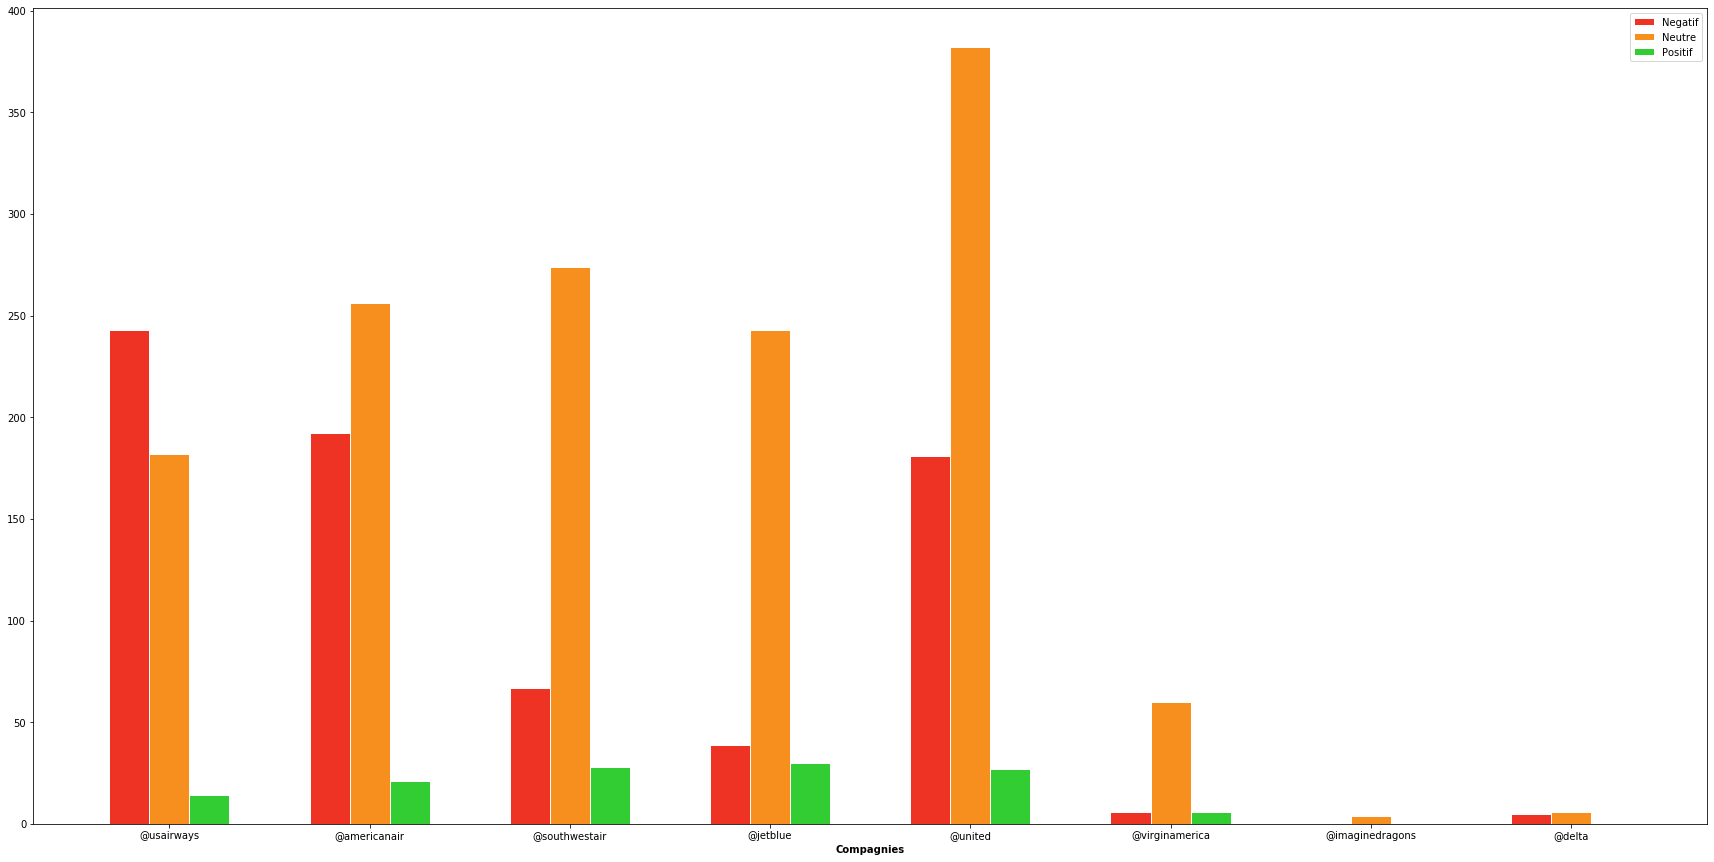

"\nLe diagramme représente le nombre de tweets négatifs, neutres et positifs pour chaque compagnie identifiée, on remarque \nque la le sentiment neutre a une distribution plutot importantes pour la plupart des compagnies selon notre extraction. \nsuivi du sentiment négatif qui lui aussi apparait assez souvent sur les tweets car les personnes ont assez la tendance \nà exprimer leurs quotidiens de mauvaise expérience vis à vis des entreprise via twitter. On remarque que usaairways\na eu beaucoup de retour négatif selon nos données. ce diagrame peut aider les compagnies à cibler les améliorations \nde leurs services on identifiant l'information récupérer sur les tweets et on faisant la comparaisons avec leurs \ninformations pour réduire les situations de déagremment futur, aussi ce diagrame peut etre un utilisé comme état initial \npour connaitre l'évolution.\n"

In [22]:
#print(len(analyze_account(train_X)))
#https://chrisalbon.com/python/data_visualization/matplotlib_grouped_bar_plot/
companies = analyze_account(train_X) # C'est notre detect_airline
l=len(companies)
Negatif=[0]*l
Neutre=[0]*l
Positif=[0]*l

result_test=extract_sentiment()

#print(result_test)
i=0
for compagnie in companies:
    j=0
    for tweet in test_X: 
        #print(tweet)
        if compagnie in tweet.lower():
            if(result_test[j])==0:
                Negatif[i]=Negatif[i]+1
            if(result_test[j])==1:
                Neutre[i]=Neutre[i]+1
            if(result_test[j])==2:
                Positif[i]=Positif[i]+1
        j=j+1
    i=i+1
#print(Negatif)
#print(Neutre)
#print(Positif)
                
#!pip install --user matplotlib
import matplotlib.pyplot as plt
import numpy as np

barWidth=0.2

r1=np.arange(len(Negatif))
r2=[x+barWidth for x in r1]
r3=[x+barWidth for x in r2]

plt.bar(r1, Negatif, color='#EE3224', width=barWidth, edgecolor='white', label='Negatif')
plt.bar(r2, Neutre, color='#F78F1E', width=barWidth, edgecolor='white', label='Neutre')
plt.bar(r3, Positif, color='#32CD32', width=barWidth, edgecolor='white', label='Positif')

plt.xlabel('Compagnies', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(Negatif))], companies)
plt.rcParams["figure.figsize"]=[30,15]
plt.legend()
plt.show()

"""
Le diagramme représente le nombre de tweets négatifs, neutres et positifs pour chaque compagnie identifiée, on remarque 
que la le sentiment neutre a une distribution plutot importantes pour la plupart des compagnies selon notre extraction. 
suivi du sentiment négatif qui lui aussi apparait assez souvent sur les tweets car les personnes ont assez la tendance 
à exprimer leurs quotidiens de mauvaise expérience vis à vis des entreprise via twitter. On remarque que usaairways
a eu beaucoup de retour négatif selon nos données. ce diagrame peut aider les compagnies à cibler les améliorations 
de leurs services on identifiant l'information récupérer sur les tweets et on faisant la comparaisons avec leurs 
informations pour réduire les situations de déagremment futur, aussi ce diagrame peut etre un utilisé comme état initial 
pour connaitre l'amélioration
"""



## 2. Analyse de termes

Le POS-tagging (pour *part-of-speech tagging*, en français étiquetage grammatical) consiste à l'extraction de l'information grammaticale d'un token dans une phrase. Par exemple, la table ci-dessous donne un exemple du *POS-tagging* de la phrase *"The cat is white!"*


|   The   | cat  |  is  | white     |    !       |
|---------|------|------|-----------|------------|
| article | noun | verb | adjective | punctation |


Pour autant, le *POS-tagging* peut être plus complexe que les règles simples apprises à l'école. Il faut souvent des informations plus détaillées sur le rôle d'un terme dans une phrase. Pour notre problème, nous n'avons pas besoin d'utiliser un modèle linguistique plus complexe, nous allons utiliser ce qu'on appelle des *POS-tags* universelles.

En *POS-tagging*, chaque token est représenté par un tag. La liste des POS-tags utilisés sont disponibles ici :
https://universaldependencies.org/u/pos/ .

In [21]:
# NLTK POS-tagger

import nltk


#before using pos_tag function, you have to tokenize the sentence.
s = ['The', 'cat', 'is',  'white', '!']
s=bigram(s)

r=nltk.pos_tag(s,tagset='universal')
print(r)
for s in r:
    print(s[0])



[('The cat', 'NOUN'), ('cat is', 'VERB'), ('is white', 'ADJ'), ('white !', 'NOUN')]
The cat
cat is
is white
white !


##### Question 12. Implémentez un code qui collecte les 10 termes les plus fréquents pour chaque compagnie aérienne. (2 Pts)

Ici, vous n'allez considérer que les termes apparaissant dans les tweets positifs et négatifs. 

De plus, nous allons utiliser la définition suivante de "terme":

1. Un mot qui est soit un adjectif, soit un nom
2. Un N-gram composé d'adjectifs suivit par un nom (par exemple, "nice place"), ou un nom suivi par un autre nom (par exemple, "sports club").

Ensuite, **générez une table** contenant les 10 termes les plus fréquents, avec leurs fréquences (en pourcentage) pour chaque compagnie.

*N'oubliez pas de supprimer le nom de la compagnie parmi les termes !*


In [48]:
def term(tokens):
    r=nltk.pos_tag(tokens,tagset='universal')
    
from prettytable import PrettyTable
table= PrettyTable()

import re
def ten_terms_company(tweets,results,compagnies):
    lists_dict_companies={}
    words={}
    for compagnie in compagnies:# rechercher les tweet positif ou negatif dans lesqules les compagnies apparaissent
        i=0                      # ex; {americanair:[5,7}] => americanair apparait sur le tweet 5 et 7.
        local_compagnie=[]
        
        for tweet in tweets:
            if(results[i]==2) or (results[i]==0): # tweet positive ou négatif
                if compagnie in tweet.lower():
                    if compagnie in lists_dict_companies:
                        lists_dict_companies[compagnie].append(i)
                    
                    if compagnie not in local_compagnie:
                        local_compagnie.append(compagnie)
                        lists_dict_companies[compagnie]=[i]

            i=i+1
    #print(lists_dict_companies)
    l=1
    for compagnie in lists_dict_companies:
        list_local_word_by_company={}
        for row in lists_dict_companies[compagnie]:
            tweet= re.sub(compagnie, "", tweets[row])
            tweet= re.sub('@', "", tweets[row])
            tokens = nltk_tokeniser.tokenize(tweet)
            # add also the bigram
            b=bigram(tokens)
            r=nltk.pos_tag(tokens,tagset='universal')
            
            
            q=0
            while q<len(r):
                if((r[q][0]).lower()not in lists_dict_companies):
                    if((r[q][1])=="NOUN" or (r[q][1])=="ADJ" and (r[q][0]).lower()!=compagnie):

                        if(r[q][0] not in list_local_word_by_company ):
                            list_local_word_by_company[r[q][0].lower()]=1
                        else:
                            list_local_word_by_company[r[q][0].lower()]=list_local_word_by_company[r[q][0]]+1

                q=q+1

            
            
            for s in b:
                tok=nltk_tokeniser.tokenize(s)
                r_gram=nltk.pos_tag(tok,tagset='universal')
                if((r_gram[0][0]).lower()not in lists_dict_companies and (r_gram[1][0]).lower()not in lists_dict_companies):
                    if((r_gram[0][1])=="NOUN" or (r_gram[0][1])=="ADJ" and ((r_gram[1][1])=="NOUN")):
                        if(s not in list_local_word_by_company ):
                            list_local_word_by_company[s]=1
                        else:
                            list_local_word_by_company[s]=list_local_word_by_company[s]+1
        #print(list_local_word_by_company)
         
        import operator
        sorted_dictionary = sorted(list_local_word_by_company.items(), key=operator.itemgetter(1),reverse=True)
        col=["Compagnie"]
        col1=[compagnie]
        for al in sorted_dictionary[:10]:
            col.append(al[0])
            col1.append(al[1])
        #print(col1)
        table.field_names=col
        table.add_row(col1)
        print(table)
        table.clear_rows()
      
    
ten_terms_company(test_X,extract_sentiment(),analyze_account(test_X))


+-------------+------+---------+----------+-----+-------+---------+-------+-----+-----------+------+
|  Compagnie  | time | service | customer | due | phone | weather | great | one | thank you | http |
+-------------+------+---------+----------+-----+-------+---------+-------+-----+-----------+------+
| americanair |  14  |    13   |    13    |  12 |   10  |    10   |   8   |  8  |     8     |  8   |
+-------------+------+---------+----------+-----+-------+---------+-------+-----+-----------+------+
+--------------+------+--------+---------+-------+----------+------------------+------+--------+----------+------------+
|  Compagnie   | hold | flight | service | hours | customer | customer service | http | http : | flight . | Thanks for |
+--------------+------+--------+---------+-------+----------+------------------+------+--------+----------+------------+
| southwestair |  14  |   11   |    11   |   11  |    9     |        8         |  7   |   7    |    7     |     6      |
+----------

##### Question 13. Que conclure de la table généré à la question 12 pour les compagnies ? (1 Pt)


In [ ]:
#Les termes les plus influancant sur le sentiment du tweet pour chaque compagnie, par exemple thank you, 

# III/ Bonus (2 points)

Les noms de personnes, les noms de sociétés et les emplacements sont appelés "entités nommées". La reconnaissance d'entité nommée (NER, pour *Named-entity recognition*) consiste à extraire les entités nommées en les classant à l'aide de catégories prédéfinies. Dans cette section bonus, vous utiliserez un outil de NER pour extraire automatiquement des entités nommées des tweets. Cette approche est suffisamment générique pour récupérer des informations sur d’autres sociétés ou même des noms de produits et de personnes.


**Pour le bonus, vous êtes libres d'utiliser n'importe quel NER implémenté en Python.**

##### Question Bonus 1.  Implémentez un code qui génère une table contenant le top 10 des NER de la base de données. (1 point)

Cette table doit contenir les fréquences des entités nommées. Ensuite, générez un diagramme en bar qui montre le nombre de tweets positifs, négatifs ou neutres pour chacunes des 10 NER. Décrivez le résultat obtenu.


[('@JetBlue', 81), ('Cancelled Flightled', 71), ('today', 63), ('2', 52), ('tomorrow', 29), ('Late Flight', 29), ('first', 28), ('United', 26), ('4', 25), ('Cancelled Flighted', 24)]
[0 1 1 ... 1 0 1]


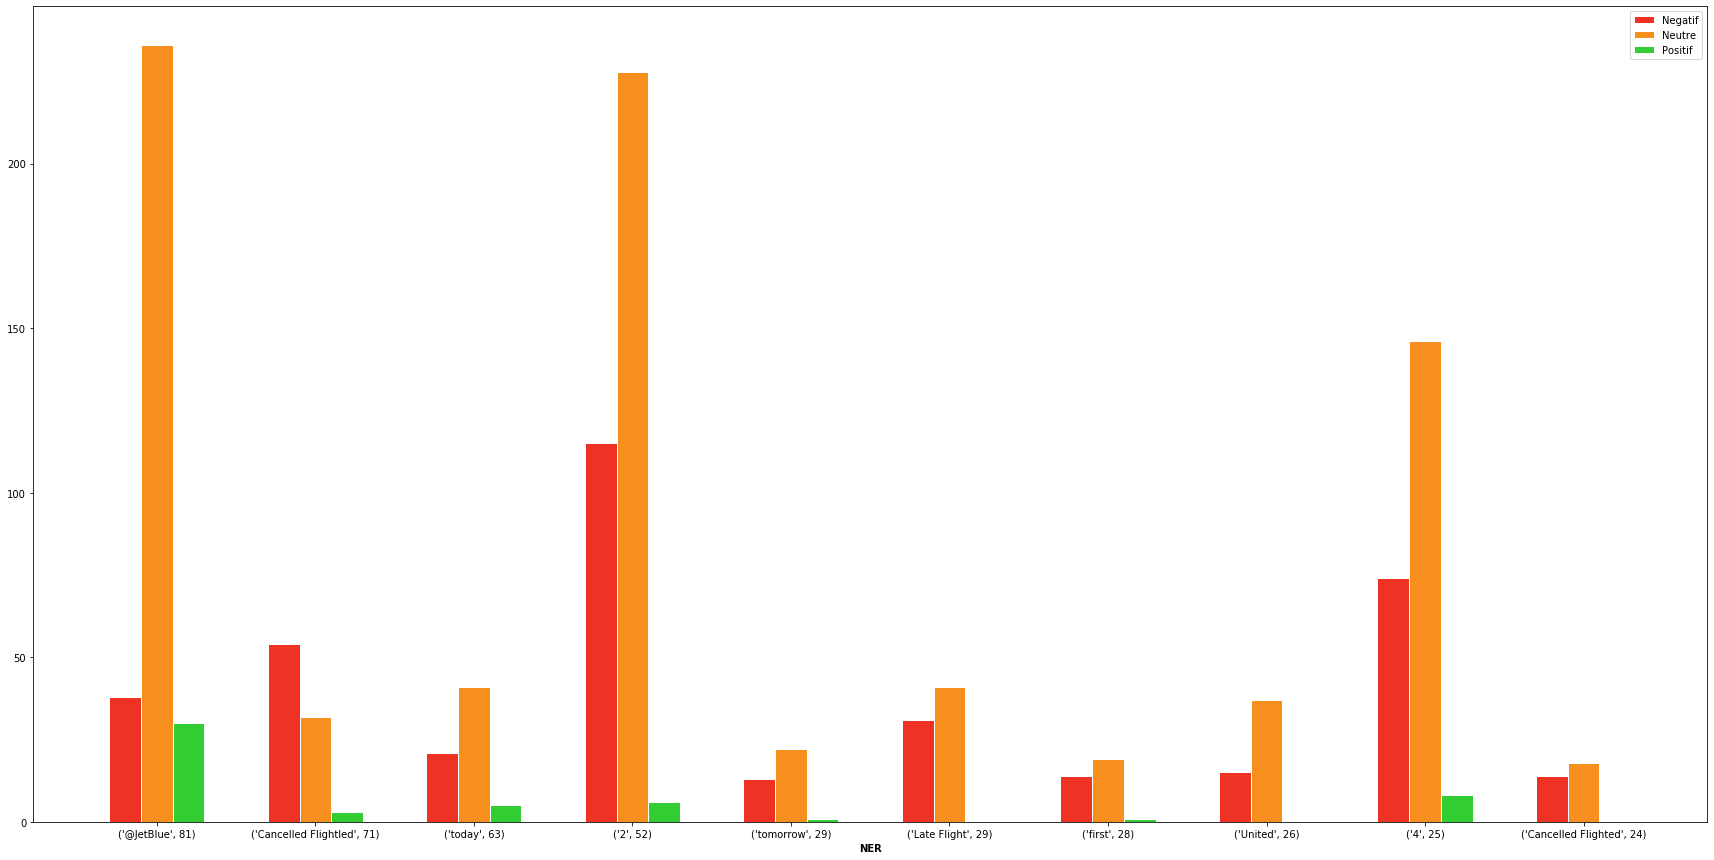

In [50]:
import spacy

nlp = spacy.load("en_core_web_sm")

a= ["@virgin I hate you Apple","@aircanada offers tickets U.K. for @ladygaga concerts",
    "@virgin is cooperating with @airamerica on an incident on the boeing 747",
    "Apple is looking at buying U.K. startup for $1 billion"]

list_NER10={}
def analyze_NER(a):
    
  
    
    list_NER={}
    list_NER_occ={}
    results=[]
    i=0

     
    for tweet in a:

        tokens = nlp(tweet)
        NER=tokens.ents
        #print(NER)
        for ner in NER:
            ner=str(ner)
            if(ner!="#"):
                if ner in list_NER_occ:
                    list_NER_occ[ner]=list_NER_occ[ner]+1
                else:
                    list_NER_occ[ner]=1
    #print(list_NER_occ)
    import operator
    sorted_dictionary = sorted(list_NER_occ.items(), key=operator.itemgetter(1),reverse=True)
    #print(sorted_dictionary[1][0])
    return(sorted_dictionary[:10])



#analyze_NER(train_X)

#print(len(analyze_account(train_X)))
#https://chrisalbon.com/python/data_visualization/matplotlib_grouped_bar_plot/
res=analyze_NER(test_X)
print(res)

result_test=extract_sentiment()

#print(result_test)
Negatif=[0]*10
Neutre=[0]*10
Positif=[0]*10

#result_test=extract_sentiment()

print(result_test)
i=0
for ner,b in res:
    j=0
    for tweet in test_X:
        #print(tweet)
        if ner in tweet:
            if(result_test[j])==0:
                Negatif[i]=Negatif[i]+1
            if(result_test[j])==1:
                Neutre[i]=Neutre[i]+1
            if(result_test[j])==2:
                Positif[i]=Positif[i]+1
        j=j+1
    i=i+1
    
#print(Negatif)
#print(Neutre)
#print(Positif)
                
import matplotlib.pyplot as plt
import numpy as np

barWidth=0.2

r1=np.arange(len(Negatif))
r2=[x+barWidth for x in r1]
r3=[x+barWidth for x in r2]

plt.bar(r1, Negatif, color='#EE3224', width=barWidth, edgecolor='white', label='Negatif')
plt.bar(r2, Neutre, color='#F78F1E', width=barWidth, edgecolor='white', label='Neutre')
plt.bar(r3, Positif, color='#32CD32', width=barWidth, edgecolor='white', label='Positif')

plt.xlabel('NER', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(Negatif))], analyze_NER(test_X))
plt.rcParams["figure.figsize"]=[30,15]
plt.legend()
plt.show()

##### Question Bonus 2. Générez une table similaire à la question 12 pour le top 10 des NER pour chaque compagnie. (1 point)

Que peut-on conclure de ces résultats?

In [49]:

#!pip install spacy
#!pip install collections


import spacy

nlp = spacy.load("en_core_web_sm")
from prettytable import PrettyTable
table1= PrettyTable()

import re
def ten_ner_company(tweets,results,compagnies):
    lists_dict_companies={}
    words={}
    for compagnie in compagnies:
        i=0
        local_compagnie=[]
        for tweet in tweets:
            if(results[i]==2) or (results[i]==0): # tweet positive
                if compagnie in tweet.lower():
                    if compagnie in lists_dict_companies:
                        lists_dict_companies[compagnie].append(i)
                    
                    if compagnie not in local_compagnie:
                        local_compagnie.append(compagnie)
                        lists_dict_companies[compagnie]=[i]

            i=i+1
    #print(lists_dict_companies)   
    for compagnie in lists_dict_companies:
        list_local_word_by_company={}
        for row in lists_dict_companies[compagnie]:
            tweet= re.sub(compagnie, "", tweets[row])
            tweet= re.sub('@', "", tweets[row])
            tweet= re.sub('#', "", tweets[row])
            tokens = nlp(tweet)
            tokens_ent=tokens.ents
            # add also the bigram
            #r=nltk.pos_tag(tokens,tagset='universal')
            
            #print(r)
            q=0
            while q<len(tokens_ent):
                if(str((tokens_ent[q])).lower() not in lists_dict_companies):
                    if(str((tokens_ent[q])).lower()!=compagnie):
                        if(str(tokens_ent[q]).lower() in list_local_word_by_company ):
                            list_local_word_by_company[str(tokens_ent[q]).lower()]=list_local_word_by_company[str(tokens_ent[q]).lower()]+1
                        else:
                            list_local_word_by_company[str(tokens_ent[q]).lower()]=1
                    
                q=q+1
        #print(compagnie+"=================")
        import operator
        sorted_dictionary = sorted(list_local_word_by_company.items(), key=operator.itemgetter(1),reverse=True)
        col=["Compagnie"]
        col1=[compagnie]
        for al in sorted_dictionary[:10]:
            
            col.append(al[0])
            col1.append(al[1])
        #print(col1)
        table1.field_names=col
        table1.add_row(col1)
        print(table1)
        table1.clear_rows()


ten_ner_company(test_X,extract_sentiment(),analyze_account(test_X)) 



+-------------+---------------------+-------+----------+---+--------+----+-------------+-----+--------------+---------+
|  Compagnie  | cancelled flightled | today | tomorrow | 2 | dallas | aa | late flight | mia | over an hour | tonight |
+-------------+---------------------+-------+----------+---+--------+----+-------------+-----+--------------+---------+
| americanair |          17         |   8   |    8     | 6 |   4    | 4  |      4      |  3  |      3       |    3    |
+-------------+---------------------+-------+----------+---+--------+----+-------------+-----+--------------+---------+
+--------------+---------------------+------------------+---------+-----+-----+-------+--------+-----------+--------------+-----+
|  Compagnie   | cancelled flightled | cancelled flight | 2 hours | atl | bna | today | 2 days | southwest | this morning | mdw |
+--------------+---------------------+------------------+---------+-----+-----+-------+--------+-----------+--------------+-----+
| southwes

In [ ]:
On conclue que la table générée avec spacy (NER) permet de montrer la relation entre un mot et sa participation dans le 
sentiment dans les tweet, sur la question de réprsentation des compagnies en bar avec les tweets positifs, négatifs 
et neutres nous avons aussi observé que americanair avait beaucoup de tweets négatifs qui est bien repris dans la table
pour cette comapgnie qui montre une fréquence élevée de cancelled flighted.
